In [1]:
# Learning tensorflow data

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
# Create dummy data
array_a = np.array([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]])
array_b = np.array([-1, -2, -3, -4, -5])
print(array_a)
print(array_b)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[-1 -2 -3 -4 -5]


In [4]:
# Dataset functions
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

In [5]:
# Define tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((array_a, array_b))
for a,b in dataset:
    print(a.numpy(), ' , ', b.numpy())

[0 1]  ,  -1
[2 3]  ,  -2
[4 5]  ,  -3
[6 7]  ,  -4
[8 9]  ,  -5


In [6]:
# Concatenate datasets
dataset0 = tf.data.Dataset.from_tensor_slices(array_b)
dataset1 = tf.data.Dataset.from_tensor_slices(array_b)
dataset_concat = dataset0.concatenate(dataset1)
for a in dataset_concat:
    print(a.numpy())

-1
-2
-3
-4
-5
-1
-2
-3
-4
-5


In [7]:
# Filtering
dataset_singles = tf.data.Dataset.from_tensor_slices(array_b)
filtered = dataset_singles.filter(lambda x: x < -3)
for a in filtered:
    print(a.numpy())

print()
dataset_arrays = tf.data.Dataset.from_tensor_slices(array_a)
filtered = dataset_arrays.filter(lambda x: x[0] > 5)
for a in filtered:
    print(a.numpy())
    
print()
filtered = dataset.filter(lambda x,y: y < -3)
for a,b in filtered:
    print(a.numpy(), ' , ', b.numpy())
    
print()
def filter_function(x,y):
    decision = y < -3
    return decision
filtered = dataset.filter(filter_function)
for a,b in filtered:
    print(a.numpy(), ' , ', b.numpy())

-4
-5

[6 7]
[8 9]

[6 7]  ,  -4
[8 9]  ,  -5

[6 7]  ,  -4
[8 9]  ,  -5


In [8]:
# Preprocessing: Apply Python functions
def tf_some_python_function(input_a, input_b):
    [input_a,] = tf.py_function(np.log1p, [input_a], [tf.float32])
    return input_a, input_b

mapped_dataset = dataset.map(tf_some_python_function,
                             num_parallel_calls=3)

for a,b in mapped_dataset:
    print(a.numpy(), ' , ', b.numpy())

[0.        0.6931472]  ,  -1
[1.0986123 1.3862944]  ,  -2
[1.609438  1.7917595]  ,  -3
[1.9459101 2.0794415]  ,  -4
[2.1972246 2.3025851]  ,  -5


In [9]:
# Batches
batch_size = 2
take_n_batch = 5

print('\nBatched data, keep partial:')            
batched_dataset = dataset.batch(batch_size, drop_remainder=False)

for i, batch in enumerate(batched_dataset.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())
        
print('\nBatched data, keep partial, repeat:')            
batched_dataset = dataset.batch(batch_size, drop_remainder=False)
batched_dataset = batched_dataset.repeat()

for i, batch in enumerate(batched_dataset.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())


Batched data, keep partial:
batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]

Batched data, keep partial, repeat:
batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]
batch 3
[[0 1]
 [2 3]]
[-1 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [10]:
# Shuffle
# shuffle, batch, repeat order should be kept
shuffled = dataset.shuffle(buffer_size=100)
shuffled = shuffled.batch(batch_size)
shuffled = shuffled.repeat()
for i, batch in enumerate(shuffled.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())

batch 0
[[6 7]
 [4 5]]
[-4 -3]
batch 1
[[2 3]
 [0 1]]
[-2 -1]
batch 2
[[8 9]]
[-5]
batch 3
[[8 9]
 [2 3]]
[-5 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [11]:
# Prefetch
# Most dataset input pipelines should end with a call to prefetch.
# This allows later elements to be prepared while the current element is being processed.
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

prefetched = dataset
prefetched = prefetched.batch(batch_size)
prefetched = prefetched.repeat()
prefetched = prefetched.prefetch(buffer_size=500)

for i, batch in enumerate(prefetched.take(take_n_batch)):
    print('batch', i)
    for arr in batch:
        print(arr.numpy())

batch 0
[[0 1]
 [2 3]]
[-1 -2]
batch 1
[[4 5]
 [6 7]]
[-3 -4]
batch 2
[[8 9]]
[-5]
batch 3
[[0 1]
 [2 3]]
[-1 -2]
batch 4
[[4 5]
 [6 7]]
[-3 -4]


In [12]:
# Timeseries forecasting (one timeseries)

In [13]:
# Define timeseries
timeseries = tf.data.Dataset.range(100000)

In [14]:
# Simple rolling window
batches = timeseries.batch(10, drop_remainder=True)

print('Rolling window:')
for i, example in enumerate(batches.take(3)):
    print('window', i, ':', example.numpy())

Rolling window:
window 0 : [0 1 2 3 4 5 6 7 8 9]
window 1 : [10 11 12 13 14 15 16 17 18 19]
window 2 : [20 21 22 23 24 25 26 27 28 29]


In [15]:
# Rolling window, window = feature data + data to be predicted
def label_next_5_steps(batch):
    return (batch[:-5], batch[-5:])

inputs_and_labels = batches.map(label_next_5_steps)

print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), " => ", label.numpy())

Split rolling window into input features and labels(predicted features):
[0 1 2 3 4]  =>  [5 6 7 8 9]
[10 11 12 13 14]  =>  [15 16 17 18 19]
[20 21 22 23 24]  =>  [25 26 27 28 29]


In [16]:
# Rolling window generalized
# Create dataset of windows out of timeseries dataset
input_feature_steps = 5
predict_steps = 3
stride = 3
shift = 2
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                            shift=shift,
                            stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':', example.numpy())

# Split rolling window into input features and labels(predicted features)
def split_at_n(batch, n):
    return batch[:-n], batch[-n:]

inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))
# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())


Rolling window:
window 0 : [ 0  3  6  9 12 15 18 21]
window 1 : [ 2  5  8 11 14 17 20 23]
window 2 : [ 4  7 10 13 16 19 22 25]

Split rolling window into input features and labels(predicted features):
[ 0  3  6  9 12] => [15 18 21]
[ 2  5  8 11 14] => [17 20 23]
[ 4  7 10 13 16] => [19 22 25]


In [17]:
# Generator in 'real' action

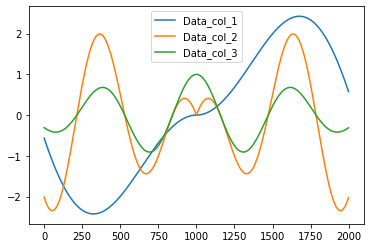

In [18]:
# Generating data and labels
def dummy_function(x):
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [a, b, c]

x = np.arange(-10, 10, 0.01)
df = pd.DataFrame(np.array([dummy_function(xi) for xi in x]), columns=['Data_col_1', 'Data_col_2', 'Data_col_3'])

df[['Data_col_1', 'Data_col_2', 'Data_col_3']].plot()

In [19]:
# Rolling window generalized
# Create timeseries dataset
timeseries = tf.data.Dataset.from_tensor_slices(df[['Data_col_1', 'Data_col_2', 'Data_col_3']].values)

# Create dataset of windows out of timeseries dataset
input_feature_steps = 3
predict_steps = 1
stride = 2
shift = 3
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                             shift=shift,
                             stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':\n', example.numpy())

# Split rolling window into input features and labels(predicted features)
def split_at_n(batch, n):
    return batch[:-n], batch[-n:]

inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))
# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())
    
# Make batches and shuffle before feeding the neural network
inputs_and_labels = inputs_and_labels.batch(32)
inputs_and_labels = inputs_and_labels.shuffle(buffer_size=100)

Rolling window:
window 0 :
 [[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]
 [-0.63185021 -2.08184907 -0.32397551]]
window 1 :
 [[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.09273269 -0.32644174]
 [-0.66513987 -2.11384243 -0.33129932]]
window 2 :
 [[-0.63185021 -2.08184907 -0.32397551]
 [-0.65407284 -2.10339745 -0.32888313]
 [-0.67617724 -2.12406674 -0.33368994]
 [-0.69816271 -2.14384986 -0.33839303]]

Split rolling window into input features and labels(predicted features):
[[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]] => [[-0.63185021 -2.08184907 -0.32397551]]
[[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.09273269 -0.32644174]] => [[-0.66513987 -2.11384243 -0.33129932]]
[[-0.63185021 -2.08184907 -0.32397551]
 [-0.65407284 -2.10339745 -0.32888313]
 [-

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape

def create_model():   
    input0 = Input(shape=(input_feature_steps, 3))
    
    flatten = Flatten() (input0)
  
    dense0 = Dense(128, activation='relu', name='1st') (flatten)
  
    dense1 = Dense(32, activation='relu', name='2nd') (dense0)
    
    output0 = Dense(predict_steps*3, name='3rd') (dense1)
    output0 = Reshape((predict_steps, 3)) (output0)
   
    model = Model(input0, output0)
  
    model.compile(optimizer='adam', loss='mse')

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
1st (Dense)                  (None, 128)               1280      
_________________________________________________________________
2nd (Dense)                  (None, 32)                4128      
_________________________________________________________________
3rd (Dense)                  (None, 3)                 99        
_________________________________________________________________
reshape (Reshape)            (None, 1, 3)              0         
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0
___________________________________________________________

In [21]:
model.fit(inputs_and_labels, epochs=10, verbose=1)

Epoch 1/10
21/21 [==============================] - 2s 110ms/step - loss: 1.4537
Epoch 2/10
21/21 [==============================] - 0s 8ms/step - loss: 0.5045
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.1736
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0482
Epoch 5/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0249
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 9/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 10/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0078


In [22]:
# Timeseries forecasting (multiple timeseries)
# Most often multiple timeseries available as data.
# If we simply concat them there will be windows which have data from multiple series.
# This solution check timeseries ids for every element in the window. Only pure windows are kept.

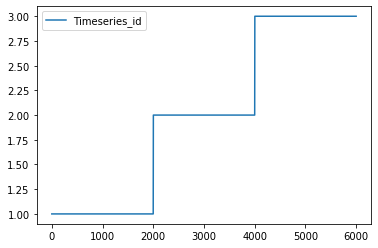

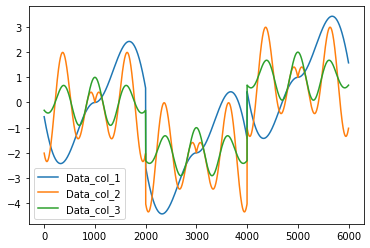

In [23]:
# Generating data and labels
def dummy_function(x):
    timeseries_nbr = 1
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [timeseries_nbr, a, b, c]

x = np.arange(-10, 10, 0.01)

df1 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])

df2 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df2 = df2 - 2
df2['Timeseries_id'] = 2

df3 = pd.DataFrame(np.array([dummy_function(xi) for xi in x]),
                  columns=['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3'])
df3 = df3 + 1
df3['Timeseries_id'] = 3

df = pd.concat([df1, df2, df3]).reset_index().drop(columns='index')

COLUMN_NBR = df.shape[1] - 1 # timeseries id is not data column

df[['Timeseries_id']].plot()
df[['Data_col_1', 'Data_col_2', 'Data_col_3']].plot()

In [24]:
df.head()

,Timeseries_id,Data_col_1,Data_col_2,Data_col_3
0,1.0,-0.564480,-2.012006,-0.308677
1,1.0,-0.575781,-2.024182,-0.311285
2,1.0,-0.587053,-2.036145,-0.313870
3,1.0,-0.598296,-2.047895,-0.316431
4,1.0,-0.609510,-2.059429,-0.318970


In [25]:
# Rolling window generalized
# Create timeseries dataset
timeseries = tf.data.Dataset.from_tensor_slices(df[['Timeseries_id', 'Data_col_1', 'Data_col_2', 'Data_col_3']].values)

# Create dataset of windows out of timeseries dataset
input_feature_steps = 3
predict_steps = 1
stride = 2
shift = 3
window_size = input_feature_steps + predict_steps
windows = timeseries.window(size=window_size,
                             shift=shift,
                             stride=stride)

# Batchify then flatten the dataset of batches into a dataset of their elements
windows = windows.flat_map(lambda x: x.batch(window_size, drop_remainder=True))

print('Rolling window:')
for i, example in enumerate(windows.take(3)):
    print('window', i, ':\n', example.numpy())

# Split rolling window into input features and labels(predicted features)
features = df.shape[1] - 1 # timeseries id is not a feature
ifd = tf.zeros((input_feature_steps, features), dtype=tf.float64, name='input_feature_dummy')
psd = tf.zeros((predict_steps, features), dtype=tf.float64, name='predict_steps_dummy')
def split_at_n(batch, n):
    # Expect the first column to be the timeseries id
    
    # Check if timeseries ids in the tensor equals the first id
    is_different = tf.math.not_equal(batch[:, 0], batch[0, 0])
    if tf.math.count_nonzero(is_different) == 0:
        # All timeseries id is the same, return data
        return batch[:-n, 1:], batch[-n:, 1:]
    else:
        # At least one timeseries id is different, return zero tensors
        return ifd, psd
inputs_and_labels = windows.map(lambda x: split_at_n(x, n=predict_steps))

# Drop windows which were set to zero (not enough data at the end of the timeseries)
def filter_fn(x, y):
    # Evaluate elementwise: x[i] != 0 (0 -> False, anything else -> True)
    x_is_zero = tf.math.not_equal(x, ifd)
    y_is_zero = tf.math.not_equal(y, psd)
    
    # Count elements in tensor which are True(non-zero)
    x_nonzero = tf.math.count_nonzero(x_is_zero)
    y_nonzero = tf.math.count_nonzero(y_is_zero)
    
    # If any element in x or y is non-zero then keep it
    return (x_nonzero + y_nonzero) > 0
inputs_and_labels = inputs_and_labels.filter(filter_fn)

# .prefetch(x) for faster pipeline

print()
print('Split rolling window into input features and labels(predicted features):')
for input_feature, label in inputs_and_labels.take(3):
    print(input_feature.numpy(), "=>", label.numpy())
    
# Make batches and shuffle before feeding the neural network
inputs_and_labels = inputs_and_labels.batch(32)
inputs_and_labels = inputs_and_labels.shuffle(buffer_size=100)

Rolling window:
window 0 :
 [[ 1.         -0.56448003 -2.01200565 -0.30867717]
 [ 1.         -0.58705309 -2.03614517 -0.31386957]
 [ 1.         -0.60951006 -2.05942904 -0.31897001]
 [ 1.         -0.63185021 -2.08184907 -0.32397551]]
window 1 :
 [[ 1.         -0.59829613 -2.04789458 -0.31643147]
 [ 1.         -0.62069478 -2.07074753 -0.32148481]
 [ 1.         -0.64297626 -2.09273269 -0.32644174]
 [ 1.         -0.66513987 -2.11384243 -0.33129932]]
window 2 :
 [[ 1.         -0.63185021 -2.08184907 -0.32397551]
 [ 1.         -0.65407284 -2.10339745 -0.32888313]
 [ 1.         -0.67617724 -2.12406674 -0.33368994]
 [ 1.         -0.69816271 -2.14384986 -0.33839303]]

Split rolling window into input features and labels(predicted features):
[[-0.56448003 -2.01200565 -0.30867717]
 [-0.58705309 -2.03614517 -0.31386957]
 [-0.60951006 -2.05942904 -0.31897001]] => [[-0.63185021 -2.08184907 -0.32397551]]
[[-0.59829613 -2.04789458 -0.31643147]
 [-0.62069478 -2.07074753 -0.32148481]
 [-0.64297626 -2.092

In [26]:
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
1st (Dense)                  (None, 128)               1280      
_________________________________________________________________
2nd (Dense)                  (None, 32)                4128      
_________________________________________________________________
3rd (Dense)                  (None, 3)                 99        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 3)              0         
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0
_________________________________________________________

In [27]:
model.fit(inputs_and_labels, epochs=10, verbose=1)

Epoch 1/10
63/63 [==============================] - 1s 17ms/step - loss: 0.9303
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 0.0979
Epoch 3/10
63/63 [==============================] - 1s 8ms/step - loss: 0.0321
Epoch 4/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0169
Epoch 5/10
63/63 [==============================] - 1s 8ms/step - loss: 0.0105
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.0094
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 0.0076
Epoch 8/10
63/63 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 9/10
63/63 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 10/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0056
